## Project-Exam 1

5. Pick any dataset online for theclassification problem which includes both numeric and non-numeric features <br>
a. Perform exploratory data analysis on the data set (it can be anything on your choice that gives insight about the dataset)<br>
b. Apply  the  three  classification  algorithms  Naïve Bayes,  SVM  and  KNN  on  the chosen data set and report which classifier gives better result.<br>
c. Try  SVM  with  linear  and  non-linear  kernel  and  report  which  one  gives  better performance<br>

* k-Nearest Neighbour (Classificiation)
* Naive Bayes (Classificiation)
* Support Vector Machine (Classificiation) - Linear and RBF kernel

In [27]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted.<br>It includes following fields:<br>
**Field** : Description<br>**Loan_status** : Whether a loan is paid off on in collection (Categorical)<br>**Principal** : Basic principal loan amount at the (Numeric)<br>**Terms** : Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule (Categorical)<br>**Effective_date** : When the loan got originated and took effects (Date: Non-Numeric)<br>**Due_date** : Since it’s one-time payoff schedule, each loan has one single due date (Date: Non-Numeric)<br>**Age** : Age of applicant (Numeric)<br>**Education** : Education of applicant (Categorical)<br>**Gender** : The gender of applicant (Categorical)

In [28]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [29]:
df.shape

(346, 10)

### Convert to dates to date-time objects

In [30]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Exploratory Data Analysis (EDA)
Let’s see how many of each class is in our data set

In [31]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

**260 people** have paid off the loan on time while **86** have gone into collection

Lets plot some columns to underestand data better:

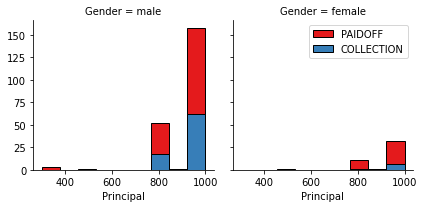

In [32]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

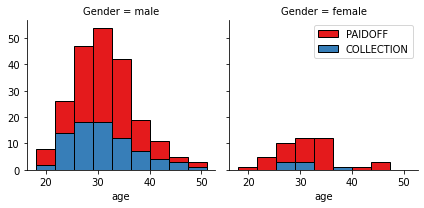

In [33]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Pre-processing: Feature selection/extraction
Lets look at the day of the week people get the loan

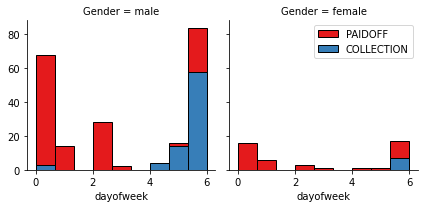

In [34]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [35]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert Categorical features to numerical values
Lets look at gender:

In [36]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

**86 % of females** pay their loans while **only 73 % of males** pay their loans.<br>

Lets convert male to 0 and female to 1:

In [37]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding
How about education?

In [38]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

We can use one-hot encoding technique to convert categorical varables to binary variables and append them to the features Data Frame

In [40]:
feature_df = df[['Principal','terms','age','Gender','weekend']]
feature_df = pd.concat([feature_df,pd.get_dummies(df['education'])], axis=1)
feature_df.drop(['Master or Above'], axis=1, inplace=True)
feature_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection
Lets define feature sets, X:

In [41]:
X = feature_df
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Labels

In [42]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize Data
Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [43]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

c:\users\sri\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

### Test Train Split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Classification
## 1. NAIVE BAYES (NB)
Naive Bayes classifies objects based on Bayes' Theorem with an assumption that the predictors (features) are independent of each other.<br>Bayes theorem is a way to calculate posterior probability P(c|x) from the P(c), P(x), P(x|c).<br>Naive Bayes is naive because it assumes the presence of a particular feature is completely unrelated to the presence of another, and each of them contribute to the posterior probability independently.<br>Therefore the posterior probability could be expressed as follows:
![Bayes' Theorem](https://anniepyim.github.io/kaggle_images/Bayes_rule.png)
[Bayes' Theorem](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/)<br>
We could use Naive Bayes to calculate the probability of some class c given the condition x.

**Step 1**: We convert the data to a frequency table.<br>
**Step 2**: We calculate the probability of each outcome P(c), each weather condition P(x), and the likelihood P(x|c)<br>
**Step 3**: We can then plug in the numbers into the NB equation above to calculate the probability of each outcome (class) given some weather condition P(c|x). Assign the object to the class with the highest probability<br>

In [45]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
prediction = nb.predict(X_test)

print('With NB accuracy is: ', nb.score(X_test, y_test)) # accuracy

With NB accuracy is:  0.6


It's called **Gaussian NB** because it assumes the distribution of likelihood of features P(x|c) to be **Gaussian** (normal).<br>

**Pros**:
* Fast and relatively high accuracy in multiclass problem<br>
* Performs well with less training data (when the assumption of independence hold, and the input features are categorical)<br>

**Cons**:
* Assumption of independent predictors, which is almost impossible in real life situation<br>
* Assumption of normally distributed input features, if it's continuous<br>
* If the categorical variable has a category in the test data but not in the train data, the probability of this cat will be assigned zero and prediction is not possible

## 2. K-NEAREST NEIGHBOUR (kNN)
kNN classfied an object by a majority vote of the object's neighbours, in the space of input parameter. The object is assigned to the class which is most common among its k (an integer specified by human) nearest neighbour. It is a non-parametric, lazy algorithm. It's non-parametric since it does not make any assumption on data distribution (the data does not have to be normallly distributed). It is lazy since it does not really learn any model and make generalization of the data (It does not train some parameters of some function where input X gives output y).<br>
![kNN](https://anniepyim.github.io/kaggle_images/kNN.png)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Train Model and Predict
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [48]:
yhat = kNN_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [49]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# 3. Support Vector Machine
Support Vector Machine (SVM) constructs a hyperplane (or a set of hyperplanes in higher dimensional space) in the feature space, that could separate objects into classes. A good hyperplane is the one that has the largest distance to the nearest training data-point of any class. Those nearest training data points are called Support Vectors.
![SVM](https://anniepyim.github.io/kaggle_images/SVM_1.png)
* H1 is not a good hyperplane as it doesn't separate the classes
* H2 does but only with small margin
* H3 separates them with maximum margin (distance)

### Parameters of SVM
There are three main parameters which we could play with when constructing a SVM classifier:

* Type of kernel
* Gamma value
* C value

Linear Kernel

In [50]:
from sklearn.svm import SVC

In [90]:
# Defining a function that declare a SVM classifier, with different parameters, and make predictions
def make_mesh(kerneltype, Cval, gammaval="auto"):
    svc = SVC(kernel=kerneltype, C=Cval, gamma=gammaval)
    svc.fit(X_train_2features, y_train_2)
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return (Z)

### Weekday and Gender

Text(0.5, 1.0, 'SVC with linear kernel')

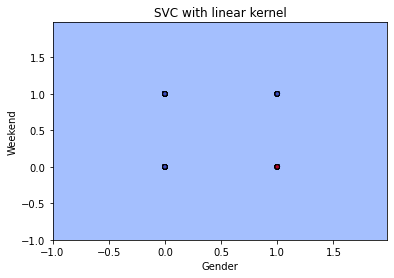

In [104]:
X_train_2features = feature_df.iloc[:,3:5]
y_train_2 = df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1])

# Define the boundaries for the graphs we will draw later
x_min, x_max = X_train_2features.iloc[:,0].min() - 1, X_train_2features.iloc[:,0].max() + 1
y_min, y_max = X_train_2features.iloc[:,1].min() - 1, X_train_2features.iloc[:,1].max() + 1
h = -(x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

Z = make_mesh("linear", 1, gammaval="auto")
plt.subplot(1, 1, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X_train_2features.iloc[:,0], X_train_2features.iloc[:,1], c=y_train_2, cmap=plt.cm.coolwarm,s=20, edgecolors='k')
plt.xlabel('Gender')
plt.ylabel('Weekend')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')

Text(0.5, 1.0, 'SVC with rbf kernel')

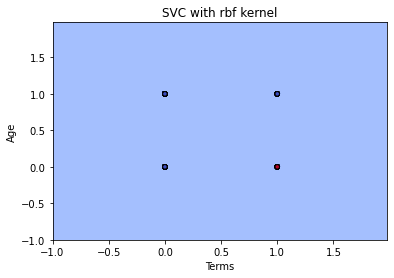

In [105]:
Z = make_mesh("rbf", 1, gammaval="auto")
plt.subplot(1, 1, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X_train_2features.iloc[:,0], X_train_2features.iloc[:,1], c=y_train_2, cmap=plt.cm.coolwarm,s=20, edgecolors='k')
plt.xlabel('Terms')
plt.ylabel('Age')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with rbf kernel')

## Age and Terms

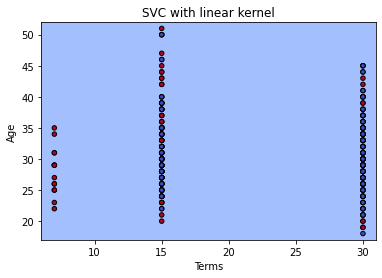

In [118]:
X_train_2features = feature_df.iloc[:,1:3]

# Define the boundaries for the graphs we will draw later
x_min, x_max = X_train_2features.iloc[:,0].min() - 1, X_train_2features.iloc[:,0].max() + 1
y_min, y_max = X_train_2features.iloc[:,1].min() - 1, X_train_2features.iloc[:,1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

Z = make_mesh("linear", 1, gammaval="auto")
plt.subplot(1, 1, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X_train_2features.iloc[:,0], X_train_2features.iloc[:,1], c=y_train_2, cmap=plt.cm.coolwarm,s=20, edgecolors='k')
plt.xlabel('Terms')
plt.ylabel('Age')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

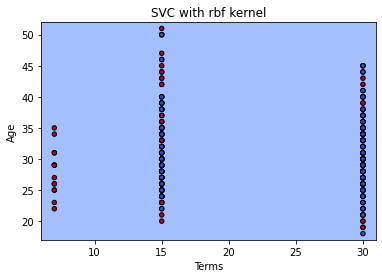

In [119]:
Z = make_mesh("rbf", 1, gammaval="auto")
plt.subplot(1, 1, 1)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X_train_2features.iloc[:,0], X_train_2features.iloc[:,1], c=y_train_2, cmap=plt.cm.coolwarm,s=20, edgecolors='k')
plt.xlabel('Terms')
plt.ylabel('Age')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with rbf kernel')
plt.show()

In [121]:
linear_svm = SVC(kernel='linear', max_iter = -1)
linear_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [123]:
yhatSVM = linear_svm.predict(X_test)
yhatSVM[0:10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [122]:
nonlinear_svm = SVC(kernel='rbf', max_iter = -1)
nonlinear_svm.fit(X_train, y_train) 

c:\users\sri\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [124]:
yhatSVM = nonlinear_svm.predict(X_test)
yhatSVM[0:10]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Load and Pre-process test data

In [127]:
test_df = pd.read_csv('loan_test.csv')
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
test_y = test_df['loan_status'].values
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

### Naive Bayes performance

In [136]:
NB_yhat = nb.predict(test_X)
print("Naive Bayes Jaccard index: %.2f" % jaccard_similarity_score(test_y, NB_yhat))
print("Naive Bayes F1-score: %.2f" % f1_score(test_y, NB_yhat, average='weighted') )

Naive Bayes Jaccard index: 0.67
Naive Bayes F1-score: 0.69


### kNN performance

In [130]:
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.79
KNN F1-score: 0.78


### Linear SVM performance

In [133]:
SVM_yhat = linear_svm.predict(test_X)
print("Linear SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("Linear SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.74
SVM F1-score: 0.63


c:\users\sri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Non-Linear SVM performance

In [135]:
SVM_yhat = nonlinear_svm.predict(test_X)
print("Non-Linear SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("Non-Linear SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

Non-Linear SVM Jaccard index: 0.80
Non-Linear SVM F1-score: 0.76


## Report
The accuracy of the built model using different evaluation metrics:

|Algorithm | Jaccard |	F1-score	|
|------|------|------|
|Naive Bayes	|0.67	|0.69	|
|kNN	|0.79	|0.78	|
|Linear SVM	|0.74	|0.63	|
|Non-Linear SVM|0.80	|0.76	|

**End**